# Imports

In [210]:
from collections import Counter
import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.transformers import FeatureSelector

from utils import variance_thresholding, standardize

In [211]:
PROCESSED_DATA_DIR = "processed_data"

# Utilities

In [212]:
def plot_feature_counts(feature_counts: List[Tuple], settings: str, figsize=(8, 6)) -> None:
    """
    Plots counts of features as a horizontal bar plot.
    
    :param feature_counts: list of tuples (feature_name, feature_count)
    """
    names = [name for name, count in feature_counts]
    counts = [count for name, count in feature_counts]

    y_pos = np.arange(len(names))

    fig, ax = plt.subplots(figsize=figsize)

    hbars = ax.barh(y_pos, counts, align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel("Feature count")
    ax.set_title(f"Selected feature counts, {settings}")

    plt.show()


## Parameters and constants

In [213]:
classifiers = {
    "LR": LogisticRegression(
        penalty="elasticnet",
        random_state=0,
        solver="saga",
        max_iter=5000
    ),
    "SVM": SVC(
        kernel="rbf",
        cache_size=512
    ),
    "RF": RandomForestClassifier(
        n_estimators=500,
        criterion="entropy"
    )
}


param_grids = {
    "LR": {
        "C": [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50, 100, 500, 1000],
        "class_weight": [None, "balanced"],
        "l1_ratio": [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
                     0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    },
    "SVM": {
        "C": np.logspace(10e-3, 10e3, num=50),
        "gamma": np.logspace(10e-3, 10e3, num=50),
        "class_weight": [None, "balanced"]
    },
    "RF": {
        "class_weight": [None, "balanced", "balanced_subsample"]
    }
}

C:\Users\jakub\anaconda3\envs\Mental_discorder_TS_feature_engineering\lib\site-packages\numpy\core\function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


# Minimal settings features

In [214]:
def feature_counts_minimal(datasets: Dict[str, pd.DataFrame], y: np.ndarray) -> Dict[str, List[Tuple]]:
    selected_features = {"full_24h": Counter(), "night": Counter(), "day": Counter()}

    for part in ["full_24h", "night", "day"]:
        X = datasets[part]

        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        for train_idx, test_idx in folds.split(X, y):
            X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
            X_train, X_test = variance_thresholding(X_train, X_test, threshold=0.05)
            
            # all features have names "activity__(proper feature name)"; we drop the "activity__" prefix
            features = [feature_name.split("__")[1] for feature_name in X_train.columns]
            selected_features[part] += Counter(features)
    
    selected_features = {name: count.most_common() for name, count in selected_features.items()}
    
    return selected_features

## Depresjon

In [215]:
dataset_str = "depresjon"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_minimal_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_minimal(datasets, y)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

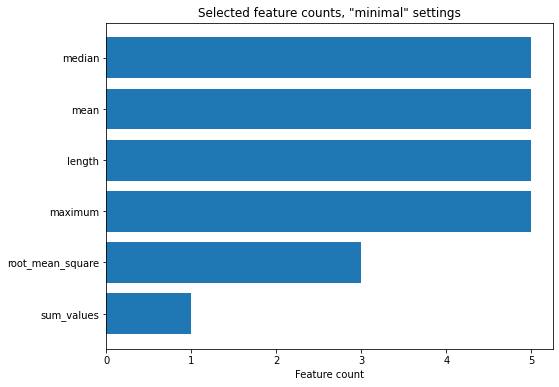

In [216]:
plot_feature_counts(features_full24h, "\"minimal\" settings")

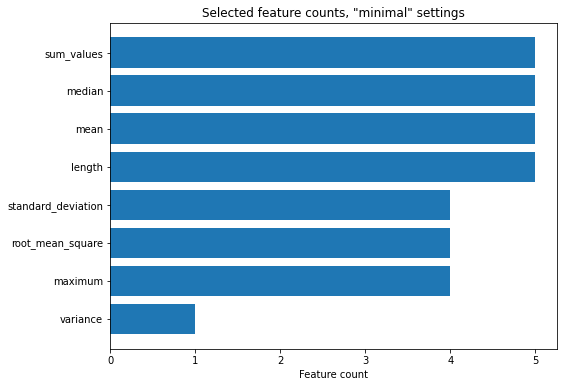

In [217]:
plot_feature_counts(features_night, "\"minimal\" settings")

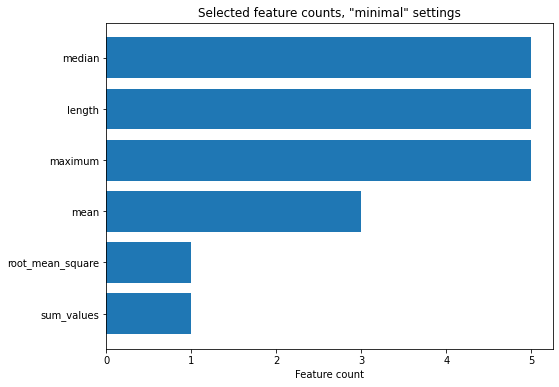

In [218]:
plot_feature_counts(features_day, "\"minimal\" settings")

## Psykose

In [219]:
dataset_str = "psykose"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_minimal_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_minimal(datasets, y)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

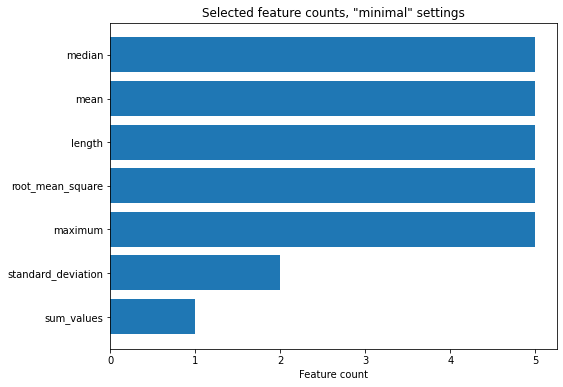

In [220]:
plot_feature_counts(features_full24h, "\"minimal\" settings")

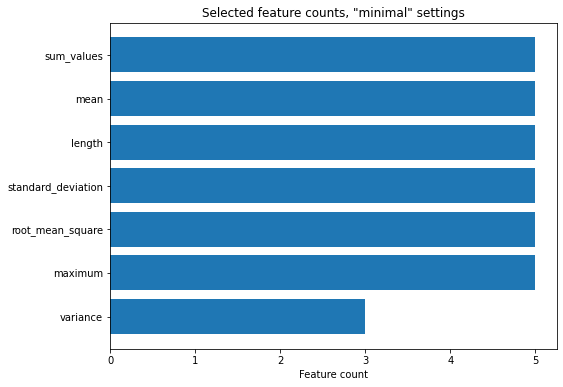

In [221]:
plot_feature_counts(features_night, "\"minimal\" settings")

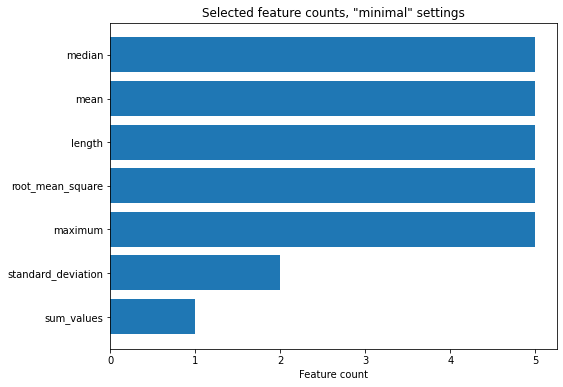

In [222]:
plot_feature_counts(features_day, "\"minimal\" settings")

# Efficient settings features, increasing FDR

In [223]:
def feature_counts_increasing_FDR(datasets: Dict[str, pd.DataFrame], y: np.ndarray) -> Dict[str, List[Tuple]]:
    selected_features = {"full_24h": Counter(), "night": Counter(), "day": Counter()}

    for part in ["full_24h", "night", "day"]:
        X = datasets[part]

        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        for train_idx, test_idx in folds.split(X, y):
            X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
            X_train, X_test = variance_thresholding(X_train, X_test, threshold=0.05)
            y_train, y_test = y[train_idx], y[test_idx]
            
            selector = None
            
            for alpha in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
                          0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]:
                selector = FeatureSelector(
                    fdr_level=alpha,
                    n_jobs=4,
                    chunksize=1
                )
                selector.fit(X_train.values, y_train)
                if len(selector.relevant_features) > 0:
                    break
            
            features = list(X_train.columns[selector.relevant_features])
            
            # all features have names "activity__(proper feature name)"; we drop the "activity__" prefix
            features = ["_".join(feature.split("__")[1:]) for feature in features]
            
            selected_features[part] += Counter(features)
    
    selected_features = {name: count.most_common() for name, count in selected_features.items()}
    
    return selected_features

## Depresjon

In [229]:
dataset_str = "depresjon"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_efficient_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_increasing_FDR(datasets, y)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

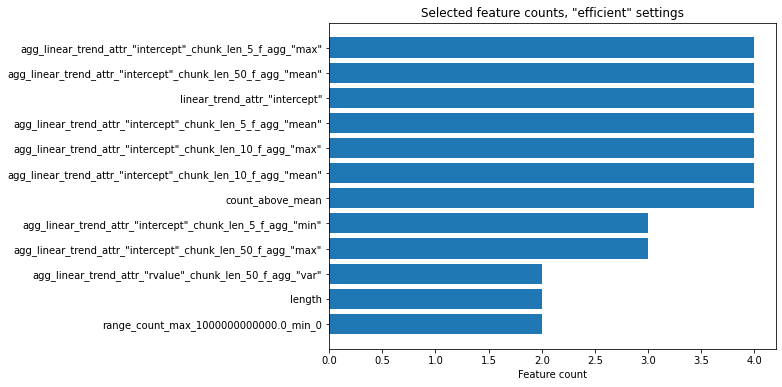

In [230]:
# we only show features that have been chosen at least 2 times, since there are a lot of them anyway
features_full24h_filtered = [(name, count) for name, count in features_full24h if count >= 2]

plot_feature_counts(features_full24h_filtered, "\"efficient\" settings")

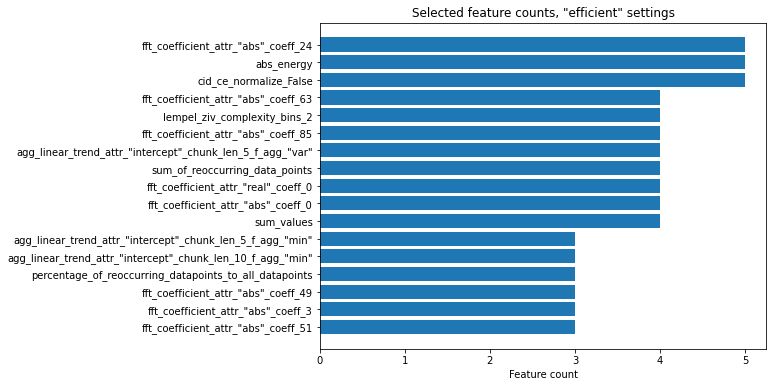

In [231]:
# we only show features that have been chosen at least 3 times, since there are a lot of them anyway
features_night_filtered = [(name, count) for name, count in features_night if count >= 3]

plot_feature_counts(features_night_filtered, "\"efficient\" settings")

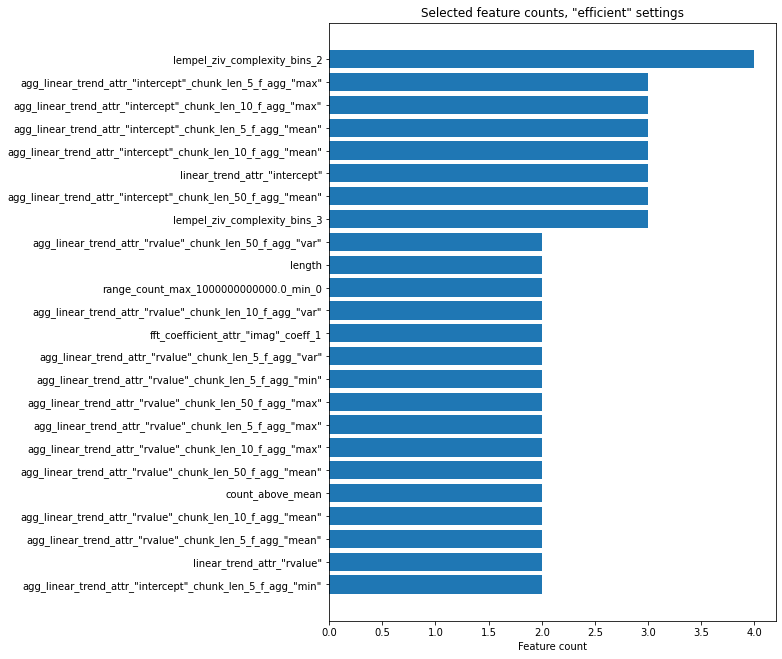

In [232]:
# we only show features that have been chosen at least 2 times, since there are a lot of them anyway
features_day_filtered = [(name, count) for name, count in features_day if count >= 2]

plot_feature_counts(features_day_filtered, "\"efficient\" settings", figsize=(8, 11))

## Psykose

In [233]:
dataset_str = "psykose"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_efficient_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_increasing_FDR(datasets, y)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

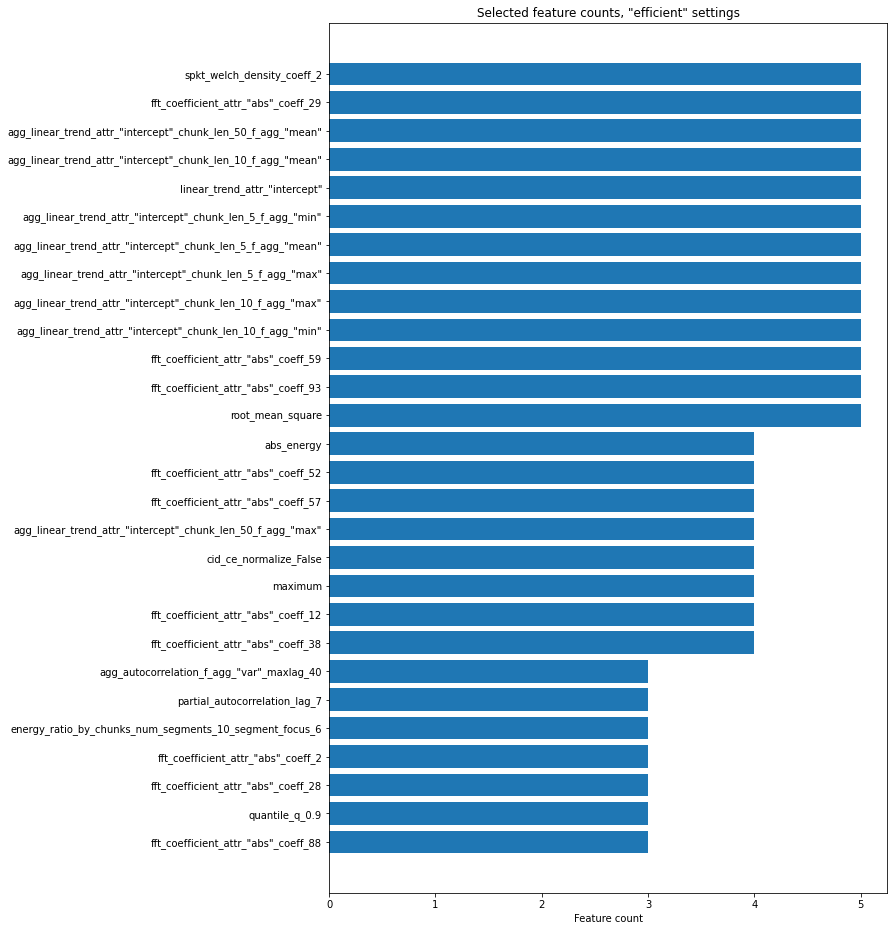

In [234]:
# we only show features that have been chosen at least 3 times, since there are a lot of them anyway
features_full24h_filtered = [(name, count) for name, count in features_full24h if count >= 3]
plot_feature_counts(features_full24h_filtered, "\"efficient\" settings", figsize=(10, 16))

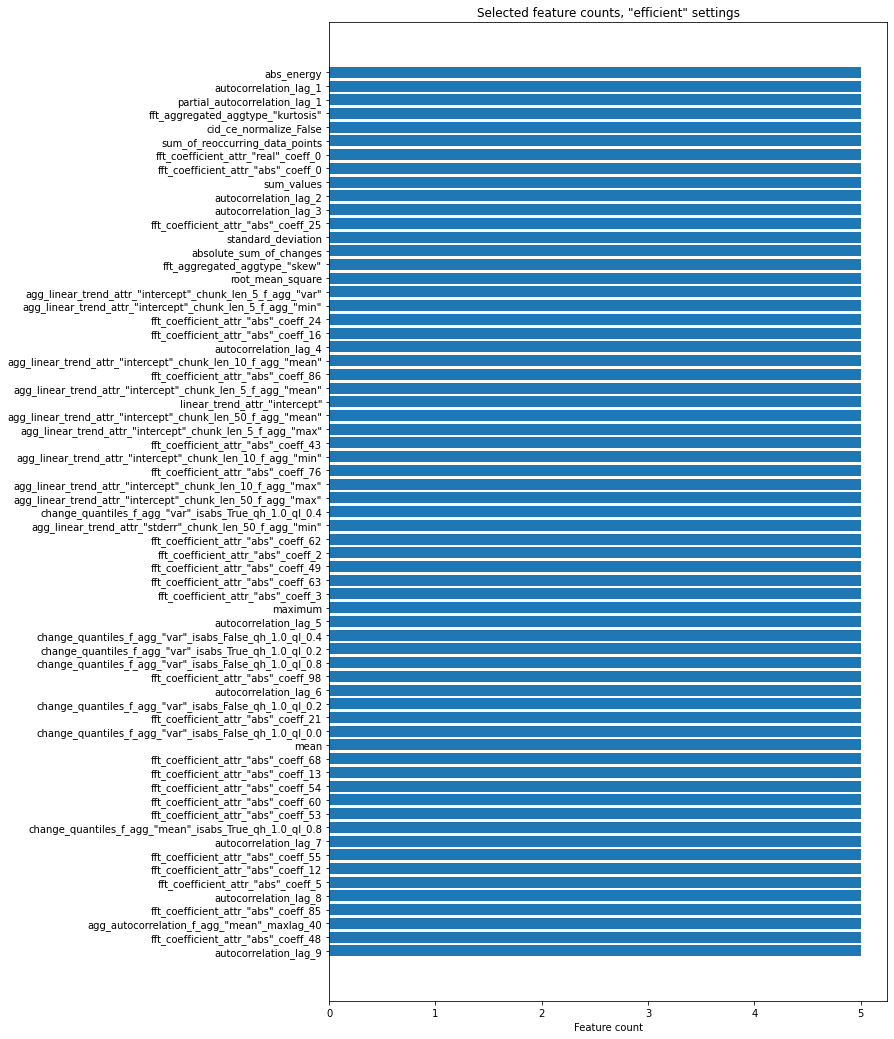

In [235]:
# we only show features that have been chosen at least 5 times, since there are a lot of them anyway
features_night_filtered = [(name, count) for name, count in features_night if count >= 5]

plot_feature_counts(features_night_filtered, "\"efficient\" settings", figsize=(10, 18))

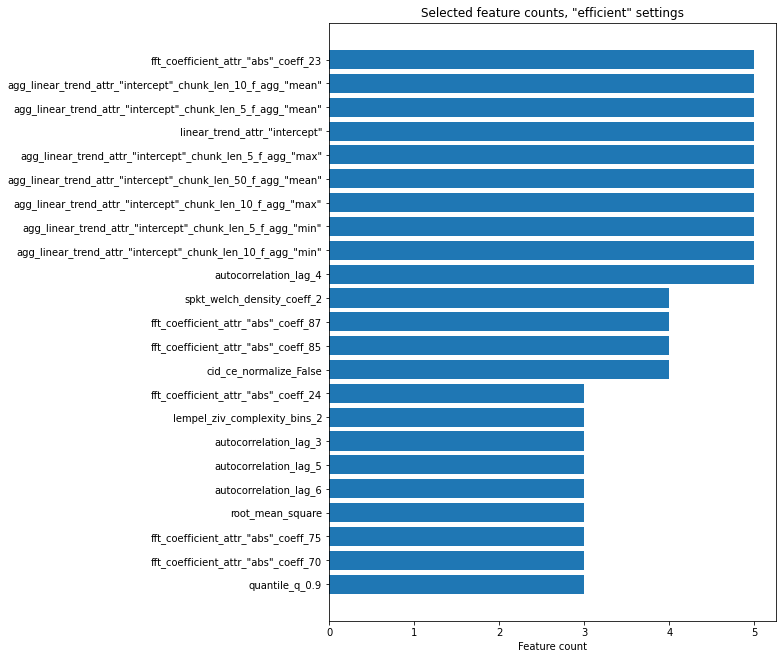

In [236]:
# we only show features that have been chosen at least 3 times, since there are a lot of them anyway
features_day_filtered = [(name, count) for name, count in features_day if count >= 3]

plot_feature_counts(features_day_filtered, "\"efficient\" settings", figsize=(8, 11))

# Efficient settings features, top N

In [261]:
def feature_counts_top_N(datasets: Dict[str, pd.DataFrame], y: np.ndarray, n: int) -> Dict[str, List[Tuple]]:
    selected_features = {"full_24h": Counter(), "night": Counter(), "day": Counter()}

    for part in ["full_24h", "night", "day"]:
        X = datasets[part]

        folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

        for train_idx, test_idx in folds.split(X, y):
            X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
            X_train, X_test = variance_thresholding(X_train, X_test, threshold=0.05)
            
            y_train, y_test = y[train_idx], y[test_idx]
            y_train = pd.Series(data=y_train, index=X_train.index)
            
            relevance_table = calculate_relevance_table(X_train, y_train)
            relevance_table.sort_values("p_value", inplace=True)
            features = relevance_table.head(n)["feature"]
            
            # all features have names "activity__(proper feature name)"; we drop the "activity__" prefix
            features = ["_".join(feature_name.split("__")[1:]) for feature_name in list(features.values)]
            selected_features[part] += Counter(features)
    
    selected_features = {name: count.most_common() for name, count in selected_features.items()}
    
    return selected_features

## Depresjon, N=5

In [262]:
dataset_str = "depresjon"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_efficient_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_top_N(datasets, y, n=5)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

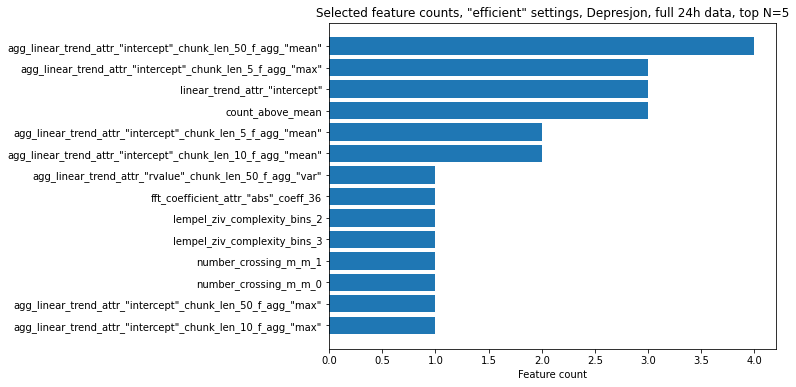

In [263]:
plot_feature_counts(features_full24h, "\"efficient\" settings, Depresjon, full 24h data, top N=5")

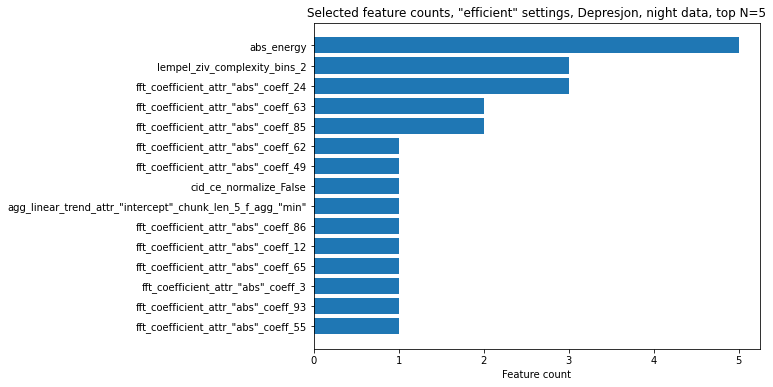

In [264]:
plot_feature_counts(features_night, "\"efficient\" settings, Depresjon, night data, top N=5")

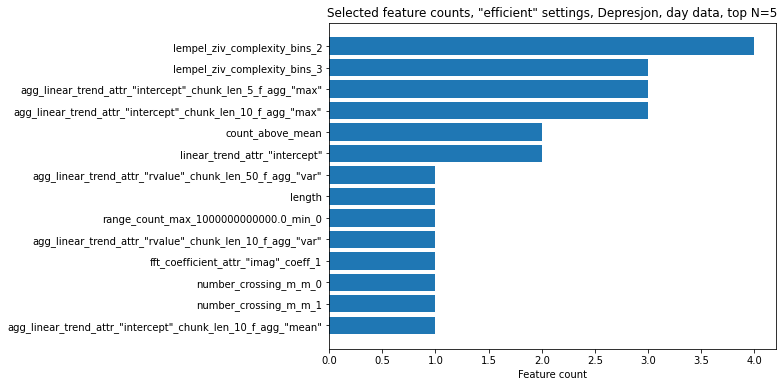

In [265]:
plot_feature_counts(features_day, "\"efficient\" settings, Depresjon, day data, top N=5")

## Depresjon, N=10

In [266]:
dataset_str = "depresjon"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_efficient_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_top_N(datasets, y, n=10)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

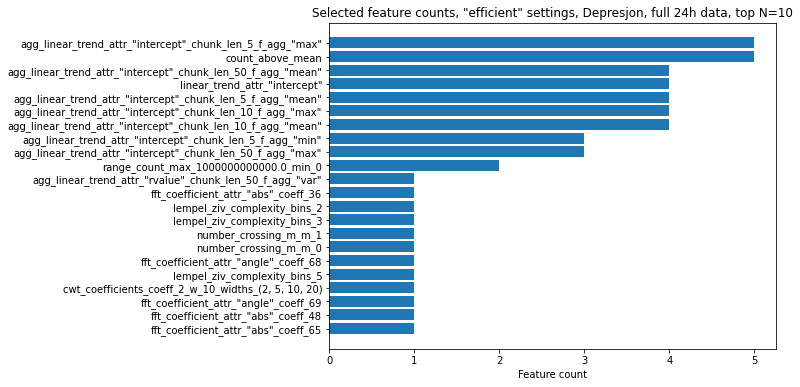

In [267]:
plot_feature_counts(features_full24h, "\"efficient\" settings, Depresjon, full 24h data, top N=10")

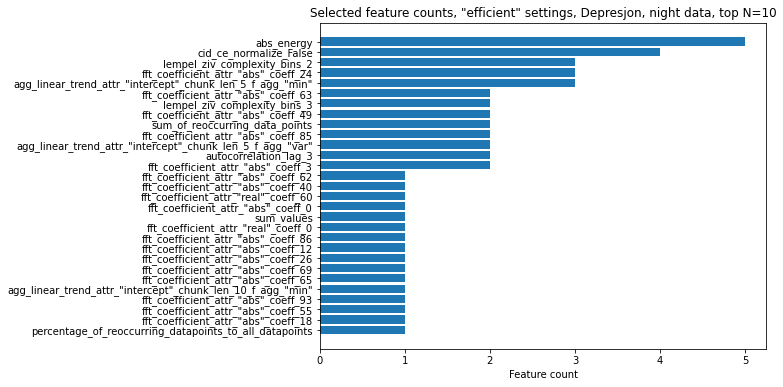

In [268]:
plot_feature_counts(features_night, "\"efficient\" settings, Depresjon, night data, top N=10")

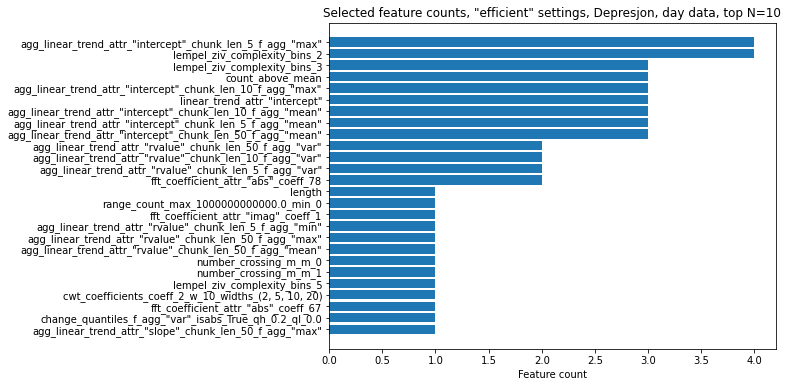

In [269]:
plot_feature_counts(features_day, "\"efficient\" settings, Depresjon, day data, top N=10")

## Psykose, N=5

In [270]:
dataset_str = "psykose"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_efficient_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_top_N(datasets, y, n=5)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

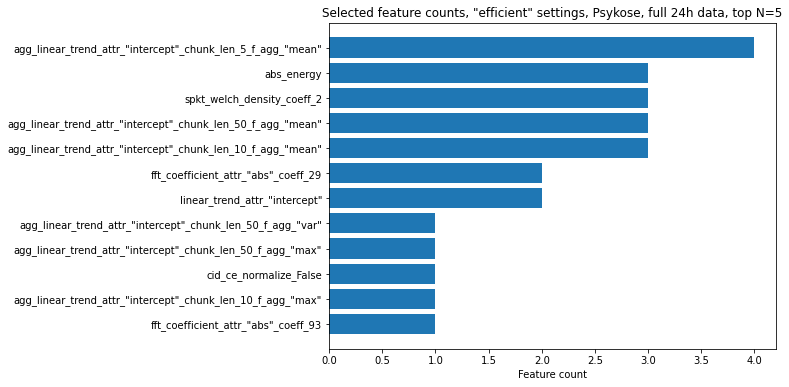

In [271]:
plot_feature_counts(features_full24h, "\"efficient\" settings, Psykose, full 24h data, top N=5")

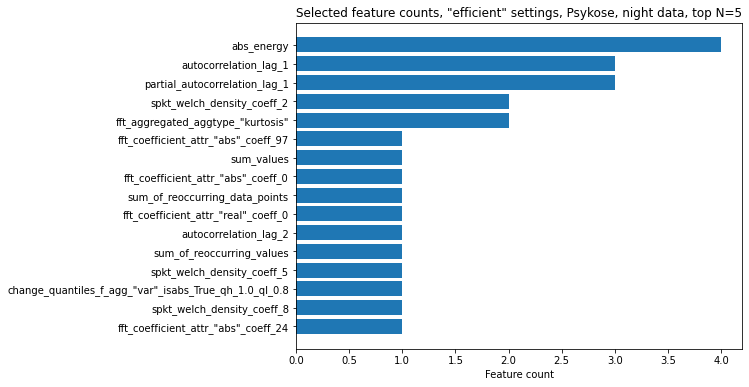

In [272]:
plot_feature_counts(features_night, "\"efficient\" settings, Psykose, night data, top N=5")

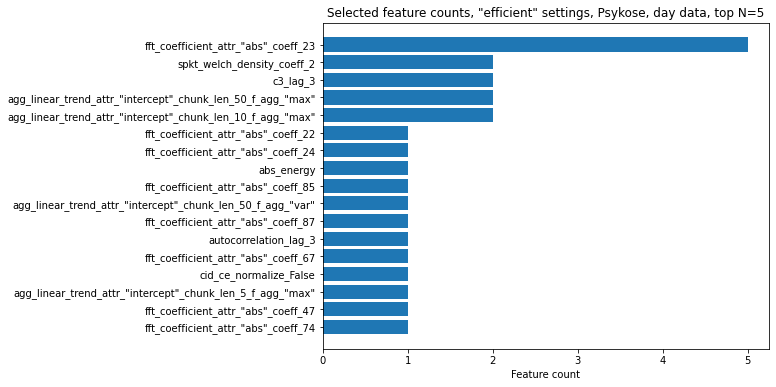

In [273]:
plot_feature_counts(features_day, "\"efficient\" settings, Psykose, day data, top N=5")

## Psykose, N=10

In [274]:
dataset_str = "psykose"

datasets = {}
for part in ["full_24h", "night", "day"]:
    filename = f"automatic_{dataset_str}_efficient_{part}.csv"
    filepath = os.path.join(PROCESSED_DATA_DIR, filename)
    X = pd.read_csv(filepath, header=0).fillna(0)
    datasets[part] = X

y = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f"{dataset_str}_y.csv"), header=None, dtype=int)
y = y.values.ravel()

selected_features = feature_counts_top_N(datasets, y, n=10)

features_full24h = selected_features["full_24h"]
features_night = selected_features["night"]
features_day = selected_features["day"]

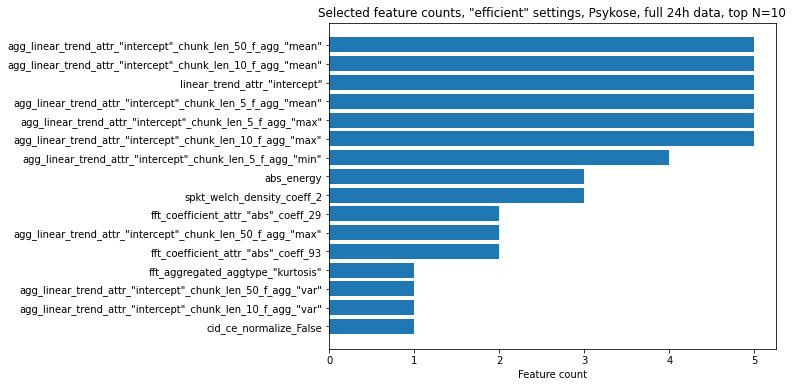

In [275]:
plot_feature_counts(features_full24h, "\"efficient\" settings, Psykose, full 24h data, top N=10")

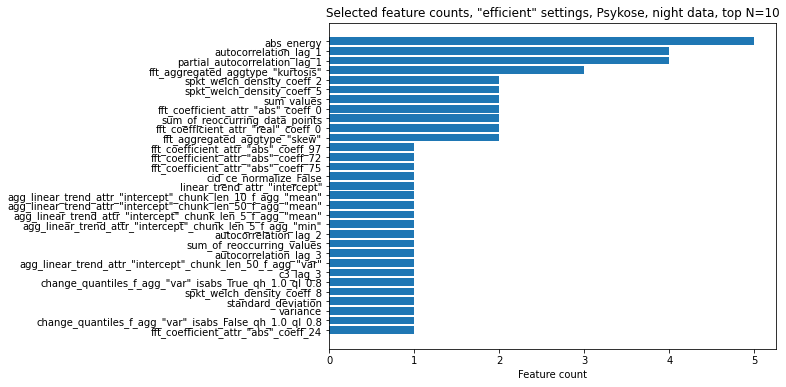

In [276]:
plot_feature_counts(features_night, "\"efficient\" settings, Psykose, night data, top N=10")

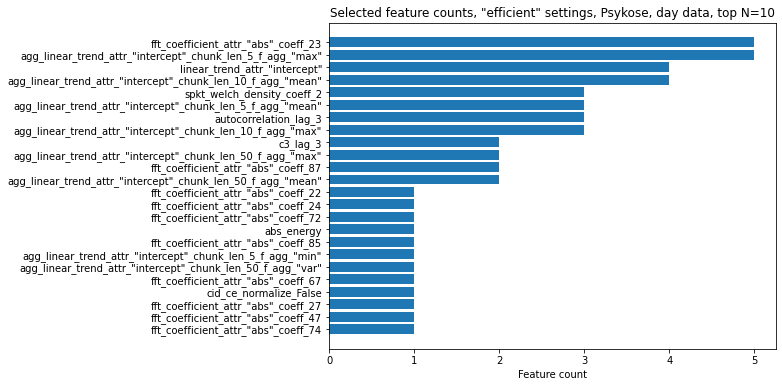

In [277]:
plot_feature_counts(features_day, "\"efficient\" settings, Psykose, day data, top N=10")